# Modelo de Machine Learning

Una vez preparados los datos, se procede a buscar un modelo de Machine Learning de clasificación, que permita clasificar a un paciente como *hospitalizado* o *no hospitalizado*, teniendo en cuenta la información referente a sus antecedentes como paciente, las morbilidad asociadas, los antecedentes relacionados con la toma de la biopsia y complicaciones infecciosas.

Para ello, se plantean dos estrategias para esa busqueda. Por un lado, utilizar las 12 columnas de datos y, en una segunda estrategia, se considera la reducción de dimensionalidad. Para ambas estrategias se utilizan los algoritmos de Árbol de Decisión, K-Vecinos Cernanos y Máquina de Soporte de Vectores.

Para la elección de los mejores hiperparámetros de cada uno de ellos, se utiliza una búsqueda exaustiva mediante la técnica de GridSearch.

A continuación, se describen cada uno de los pasos seguidos y la elección del mejor modelo.

# Importar librerías

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
sns.set_style("darkgrid")
import warnings
warnings.simplefilter("ignore")

# Carga de los datos

Cargamos los datos limpios y transformados. Exploramos el Dataframe para cer su estructura y contenido.

In [75]:
df = pd.read_csv('Datasets/Hospitalizacion_c.csv')
df.head()

,EDAD,DIABETES,PSA,BIOPSIAS PREVIAS,VOLUMEN PROSTATICO,ANTIBIOTICO UTILIZADO EN LA PROFILAXIS,NUMERO DE MUESTRAS TOMADAS,ENF. CRONICA PULMONAR OBSTRUCTIVA,BIOPSIA,FIEBRE,ITU,TIPO DE CULTIVO,HOSPITALIZACION
0,53,0,4.0,0,1,1,12,0,7,1,0,2,1
1,56,0,7.7,0,1,1,12,0,7,1,0,2,1
2,57,0,29.0,1,1,1,24,0,7,1,0,0,1
3,56,0,7.0,0,1,1,12,0,7,1,0,2,1
4,55,0,29.0,1,1,1,24,0,7,1,0,0,1


Se analiza la distribución de los datos con respecto a la variable objetivo.

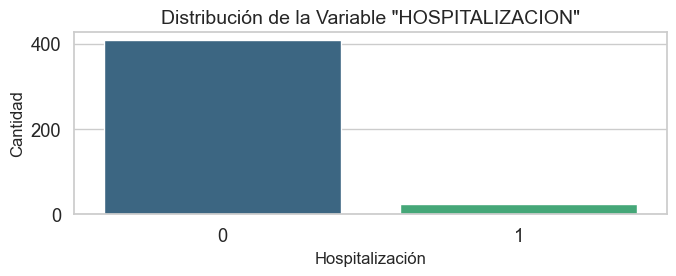

In [76]:
# Crear el countplot vertical
plt.figure(figsize=(7, 3))
sns.set(style="whitegrid", font_scale=1.2)

sns.countplot(data=df, x='HOSPITALIZACION', palette='viridis')

# Añadir etiquetas y título
plt.title('Distribución de la Variable "HOSPITALIZACION"', fontsize=14)
plt.xlabel('Hospitalización', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Se identifica un significativo desequilibrio de clases en la variable objetivo, donde la clase positiva para la hospitalización cuenta con tan solo 23 registros. En consecuencia, se ha tomado la decisión de llevar a cabo un sobremuestreo de dicha variable con el objetivo de abordar esta disparidad.

# División de los conjuntos de entrenamiento y prueba, seguido por la aplicación de sobremuestreo para abordar el desbalanceo.

Dada la notable disparidad en la variable objetivo, se opta por realizar un sobremuestreo de la clase minoritaria mediante el método `RandomOverSampler` de la biblioteca `imbalanced-learn`.

Es crucial destacar que este sobremuestreo se aplica exclusivamente a los datos de entrenamiento (train). La finalidad radica en generar instancias sintéticas de la clase minoritaria con el objetivo de equilibrar la distribución de clases y mejorar el rendimiento del modelo en la detección de la clase minoritaria. No obstante, se mantiene la integridad de los datos de prueba (test) para una evaluación realista, evitando así fugas de información al conjunto de entrenamiento. Este enfoque permite al modelo generalizar de manera efectiva sobre datos reales, promoviendo una evaluación precisa de su desempeño frente a situaciones novedosas.

In [77]:
# Se definen X e y (variables predictoras y variable objetivo)
X = df.drop('HOSPITALIZACION', axis=1)
y = df['HOSPITALIZACION']

# Se divide el conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Información sobre las etiquetas en el conjunto de entrenamiento
print(f'Número de instancias clasificadas como NO en el conjunto de entrenamiento: {y_train.value_counts()[0]}')
print(f'Número de instancias clasificadas como SI en el conjunto de entrenamiento: {y_train.value_counts()[1]}')

# Detalles sobre las etiquetas en el conjunto de prueba
print(f'Cantidad de instancias clasificadas como NO en el conjunto de prueba: {y_test.value_counts()[0]}')
print(f'Cantidad de instancias clasificadas como SI en el conjunto de prueba: {y_test.value_counts()[1]}')


Número de instancias clasificadas como NO en el conjunto de entrenamiento: 285
Número de instancias clasificadas como SI en el conjunto de entrenamiento: 16
Cantidad de instancias clasificadas como NO en el conjunto de prueba: 123
Cantidad de instancias clasificadas como SI en el conjunto de prueba: 7


In [78]:
# Se crea una instancia de RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Se aplica el sobremuestreo a los datos de entrenamiento
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Información sobre las etiquetas después del sobremuestreo en el conjunto de entrenamiento
print(f'Instancias clasificadas como NO después de sobremuestreo en el conjunto de entrenamiento: {y_train_ros.value_counts()[0]}')
print(f'Instancias clasificadas como SI después de sobremuestreo en el conjunto de entrenamiento: {y_train_ros.value_counts()[1]}')

Instancias clasificadas como NO después de sobremuestreo en el conjunto de entrenamiento: 285
Instancias clasificadas como SI después de sobremuestreo en el conjunto de entrenamiento: 285


# Estrategias de modelado

Como parte de nuestra estrategia para identificar el modelo más eficiente que pueda considerar todas las variables disponibles, se implementaron dos enfoques. En una primera etapa, se lleva a cabo un análisis exhaustivo de todas las variables en el conjunto de datos, seguido por una reducción de dimensionalidad.

La selección de modelos se basó en tres algoritmos de clasificación: K-Vecinos Cercanos (KNN), Árbol de Decisión (TREE) y Máquina de Soporte de Vectores (SVC). Para cada uno, se planteó la búsqueda de los mejores hiperparámetros mediante un Grid Search, un enfoque exhaustivo que abarca la combinación de rangos de valores para los parámetros relevantes.

En una fase inicial, se establece una grilla de hiperparámetros que se utilizará para evaluar cada modelo. Luego, se instancian los modelos y se lleva a cabo el entrenamiento para cada combinación de hiperparámetros y modelo, utilizando un proceso de validación cruzada con 5 folds en cada iteración. Los resultados de las mejores métricas obtenidas para cada modelo se registran en una lista, lo que facilita la comparación y la generación de gráficos de las matrices de confusión respectivas. Este análisis tiene como objetivo evaluar el rendimiento de cada modelo en términos de clasificación.

In [79]:
# Define el rango de hiperparámetros para KNN el GridSearch
param_grid_knn = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'leaf_size':[1,3,5,7,10],
    'algorithm':['auto', 'kd_tree']
}

# Define el rango de hiperparámetros para tre el GridSearch
param_grid_tree = {
    "criterion": ['gini', 'entropy'],
    "max_depth": range(1, 20)
}

# Define el rango de hiperparámetros para SVC el GridSearch
param_grid_SVC = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

### Realizamos el entrenamiento de los modelos

In [80]:
# Se crea una lista para almacenar los resultados de diferentes modelos
results = []

# Parámetros para Grid Search en KNN
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}

# Parámetros para Grid Search en Decision Tree
param_grid_tree = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

# Parámetros para Grid Search en SVC
param_grid_SVC = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

# Se instancia y evalua el modelo K-NN
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5)
grid_search_knn.fit(X_train_ros, y_train_ros)

best_knn_estimator = grid_search_knn.best_estimator_
best_knn_params = grid_search_knn.best_params_

y_pred_test_knn = best_knn_estimator.predict(X_test)
y_pred_train_knn = best_knn_estimator.predict(X_train_ros)

cm_train_knn = confusion_matrix(y_train_ros, y_pred_train_knn)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)

train_accuracy_knn = accuracy_score(y_train_ros, y_pred_train_knn)
train_precision_knn = precision_score(y_train_ros, y_pred_train_knn)
train_recall_knn = recall_score(y_train_ros, y_pred_train_knn)
train_f1_knn = f1_score(y_train_ros, y_pred_train_knn)

test_accuracy_knn = accuracy_score(y_test, y_pred_test_knn)
test_precision_knn = precision_score(y_test, y_pred_test_knn)
test_recall_knn = recall_score(y_test, y_pred_test_knn)
test_f1_knn = f1_score(y_test, y_pred_test_knn)

knn_metrics = {
    'Train Accuracy': train_accuracy_knn,
    'Train Precision': train_precision_knn,
    'Train Recall': train_recall_knn,
    'Train F1': train_f1_knn,
    'Test Accuracy': test_accuracy_knn,
    'Test Precision': test_precision_knn,
    'Test Recall': test_recall_knn,
    'Test F1': test_f1_knn,
}

results.append(('KNN', knn_metrics))

# Instanciar y evaluar el modelo Decision Tree
tree = DecisionTreeClassifier()
grid_search_tree = GridSearchCV(estimator=tree, param_grid=param_grid_tree, cv=5)
grid_search_tree.fit(X_train_ros, y_train_ros)

best_tree_estimator = grid_search_tree.best_estimator_
best_tree_params = grid_search_tree.best_params_

y_pred_test_tree = best_tree_estimator.predict(X_test)
y_pred_train_tree = best_tree_estimator.predict(X_train_ros)

cm_train_tree = confusion_matrix(y_train_ros, y_pred_train_tree)
cm_test_tree = confusion_matrix(y_test, y_pred_test_tree)

train_accuracy_tree = accuracy_score(y_train_ros, y_pred_train_tree)
train_precision_tree = precision_score(y_train_ros, y_pred_train_tree)
train_recall_tree = recall_score(y_train_ros, y_pred_train_tree)
train_f1_tree = f1_score(y_train_ros, y_pred_train_tree)

test_accuracy_tree = accuracy_score(y_test, y_pred_test_tree)
test_precision_tree = precision_score(y_test, y_pred_test_tree)
test_recall_tree = recall_score(y_test, y_pred_test_tree)
test_f1_tree = f1_score(y_test, y_pred_test_tree)

tree_metrics = {
    'Train Accuracy': train_accuracy_tree,
    'Train Precision': train_precision_tree,
    'Train Recall': train_recall_tree,
    'Train F1': train_f1_tree,
    'Test Accuracy': test_accuracy_tree,
    'Test Precision': test_precision_tree,
    'Test Recall': test_recall_tree,
    'Test F1': test_f1_tree,
}

results.append(('Decision Tree', tree_metrics))

# Instanciar y evaluar el modelo SVC
svc = SVC(probability=True)
grid_search_SVC = GridSearchCV(estimator=svc, param_grid=param_grid_SVC, cv=5)
grid_search_SVC.fit(X_train_ros, y_train_ros)

best_svc_estimator = grid_search_SVC.best_estimator_
best_svc_params = grid_search_SVC.best_params_

y_pred_test_svc = best_svc_estimator.predict(X_test)
y_pred_train_svc = best_svc_estimator.predict(X_train_ros)

cm_train_svc = confusion_matrix(y_train_ros, y_pred_train_svc)
cm_test_svc = confusion_matrix(y_test, y_pred_test_svc)

train_accuracy_svc = accuracy_score(y_train_ros, y_pred_train_svc)
train_precision_svc = precision_score(y_train_ros, y_pred_train_svc)
train_recall_svc = recall_score(y_train_ros, y_pred_train_svc)
train_f1_svc = f1_score(y_train_ros, y_pred_train_svc)

test_accuracy_svc = accuracy_score(y_test, y_pred_test_svc)
test_precision_svc = precision_score(y_test, y_pred_test_svc)
test_recall_svc = recall_score(y_test, y_pred_test_svc)
test_f1_svc = f1_score(y_test, y_pred_test_svc)

svc_metrics = {
    'Train Accuracy': train_accuracy_svc,
    'Train Precision': train_precision_svc,
    'Train Recall': train_recall_svc,
    'Train F1': train_f1_svc,
    'Test Accuracy': test_accuracy_svc,
    'Test Precision': test_precision_svc,
    'Test Recall': test_recall_svc,
    'Test F1': test_f1_svc,
}

results.append(('SVC', svc_metrics))



### Resultados

In [81]:
def sum_results_est(results):
    '''
    Devuelve un resumen de las métricas a partir de un diccionario que contiene el resumen.
    '''
    # Convertir la lista de resultados en un DataFrame
    data = []

    for model_name, metrics in results:
        metrics['Model'] = model_name
        data.append(metrics)

    df_summary = pd.DataFrame(data)

    # Reordenar las columnas para tener un formato más legible
    columns = ['Model', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']
    df_summary = df_summary[columns]
    return df_summary

# Luego, puedes utilizarla con tu lista de resultados
results_sum = sum_results_est(results)
results_sum

,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,KNN,1.0,1.0,1.0,1.0,0.969231,0.8,0.571429,0.666667
1,Decision Tree,1.0,1.0,1.0,1.0,0.976923,1.0,0.571429,0.727273
2,SVC,1.0,1.0,1.0,1.0,0.976923,1.0,0.571429,0.727273


In [68]:
# Se presentan los mejores parámetros para cada modelo
print('PARÁMETROS DE LOS MEJORES MODELOS')
print('KNN:', best_knn_params)
print('Decision Tree:', best_tree_params)
print('SVC:', best_svc_params)

PARÁMETROS DE LOS MEJORES MODELOS
KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
SVC: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


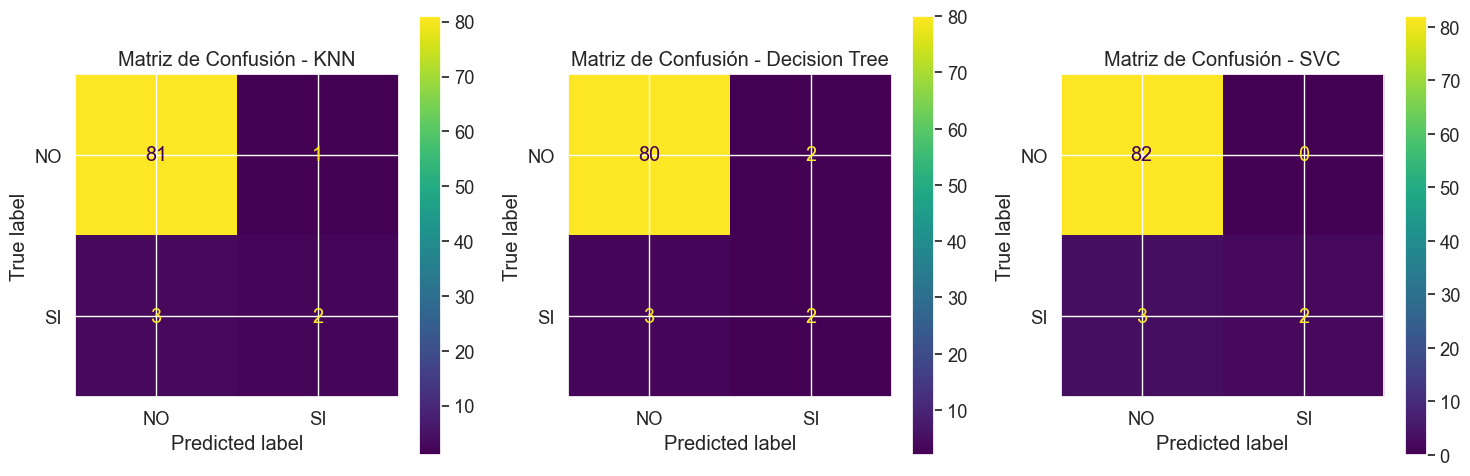

In [69]:
# Se visualizan las tres matrices de confusión
matrices = [cm_test_knn, cm_test_tree, cm_test_svc]
modelos = ['KNN', 'Decision Tree', 'SVC']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, m in enumerate(matrices):
    ax = axes[i]
    cm_display = ConfusionMatrixDisplay(m, display_labels=['NO', 'SI'])
    cm_display.plot(ax=ax)
    ax.set_title(f'Matriz de Confusión - {modelos[i]}')

plt.tight_layout()
plt.show()

En virtud de la marcada disparidad en la variable objetivo dentro de nuestro conjunto de datos, se ha adoptado el F1 Score (Test_F1) como la métrica de evaluación preferente. Esta elección se fundamenta en su capacidad para amalgamar la precisión (proporción de resultados correctos respecto al total de muestras seleccionadas) y la exhaustividad (proporción de resultados correctos respecto al total de resultados que se pretenden identificar). De este modo, se busca mantener un equilibrio ponderado entre ambas medidas.

En el caso específico de esta métrica, el modelo **Árbol de Decisión** ha exhibido el F1 Score más destacado, alcanzando un valor de 0.72. No obstante, es crucial señalar que aún persiste un margen apreciable de error en las predicciones relacionadas con individuos que eventualmente serán hospitalizados. Este aspecto se corrobora al examinar detenidamente las matrices de confusión correspondientes.

## Usando reducción de dimensionalidad (PCA)

En el contexto de esta segunda estrategia, se contempla la evaluación de los mismos modelos, considerando escenarios que implican la reducción de la dimensionalidad del conjunto de datos a diversas cantidades de componentes.

En una primera instancia, se procede a la estandarización de los datos mediante el uso de `StandardScaler`, que normaliza las variables numéricas a una distribución con media 0 y desviación estándar 1. A continuación, se definen cuatro escenarios, considerando la reducción del conjunto de variables a 3, 5, 8 y 10 componentes respectivamente. A través de un ciclo iterativo, se lleva a cabo la reducción de la dimensionalidad y el entrenamiento de cada uno de los modelos.

Las métricas óptimas para cada modelo en cada escenario de Análisis de Componentes Principales (PCA) se almacenan en un diccionario, permitiendo así una comparación detallada y una posterior visualización de los resultados.

### Se preparan los datos

In [82]:
# Se estandarizan los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ros)
X_test_scaled = scaler.transform(X_test)

### Se hace el entrenamiento

In [83]:
# Se define un diccionario para almacenar resultados
results = {}

# Se definen los números de componentes principales
num_components = [3, 5, 8, 10]

for n in num_components:
    
    # Se aplica PCA
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Se define y entrena el modelo KNN
    knn = KNeighborsClassifier()
    param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
    grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5)
    grid_search_knn.fit(X_train_pca, y_train_ros)
    
    best_knn = grid_search_knn.best_estimator_
    knn_pred_train = best_knn.predict(X_train_pca)
    knn_pred_test = best_knn.predict(X_test_pca)
    knn_best_params = grid_search_knn.best_params_

    # Se define y entrena el modelo Decision Tree
    tree = DecisionTreeClassifier()
    param_grid_tree = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    grid_search_tree = GridSearchCV(tree, param_grid_tree, cv=5)
    grid_search_tree.fit(X_train_pca, y_train_ros)

    best_tree = grid_search_tree.best_estimator_
    tree_pred_train = best_tree.predict(X_train_pca)
    tree_pred_test = best_tree.predict(X_test_pca)
    tree_best_params = grid_search_tree.best_params_

    # Se define y entrena el modelo SVC
    svc = SVC(probability=True)
    param_grid_SVC = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
    grid_search_svc = GridSearchCV(svc, param_grid_SVC, cv=5)
    grid_search_svc.fit(X_train_pca, y_train_ros)

    best_svc = grid_search_svc.best_estimator_
    svc_pred_train = best_svc.predict(X_train_pca)
    svc_pred_test = best_svc.predict(X_test_pca)
    svc_best_params = grid_search_svc.best_params_

    # Se almacenan los resultados en el diccionario
    results[n] = {
        'KNN': (knn_pred_train, knn_pred_test, best_knn),
        'Tree': (tree_pred_train, tree_pred_test, best_tree),
        'SVC': (svc_pred_train, svc_pred_test, best_svc)
    }


### Resultados

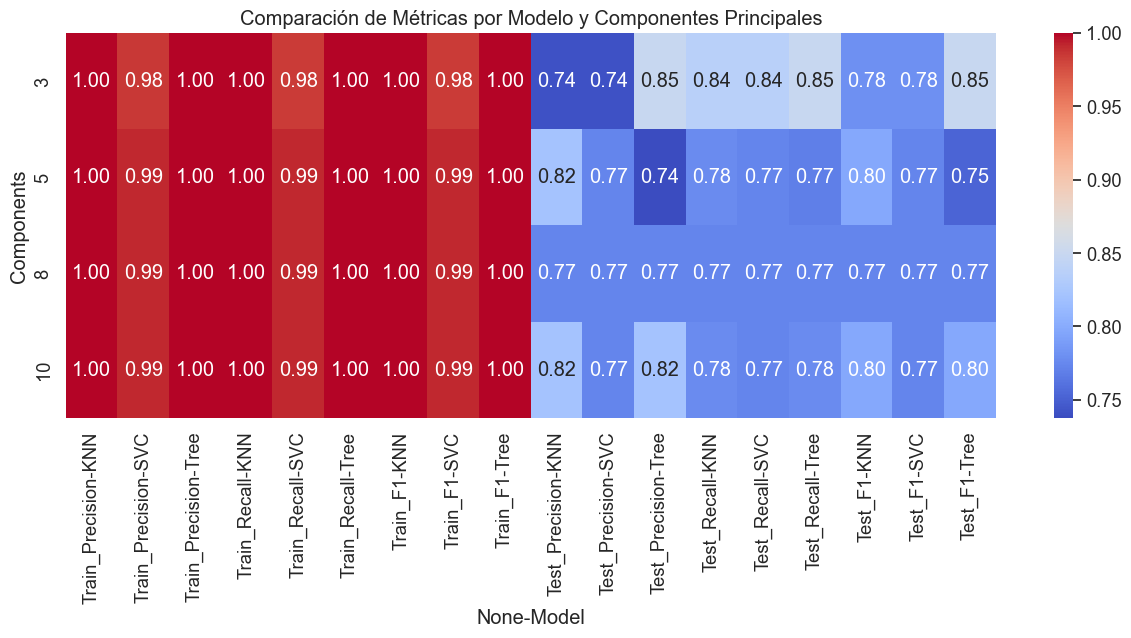

In [84]:
# Crear una lista de diccionarios para almacenar los resultados
summary_results = []

for n, models in results.items():
    for model_name, (y_train_pred, y_test_pred, best_model) in models.items():
        report_train = classification_report(y_train_ros, y_train_pred, output_dict=True)
        report_test = classification_report(y_test, y_test_pred, output_dict=True)

        summary_results.append({
            'Components': n,
            'Model': model_name,
            'Train_Precision': report_train["macro avg"]["precision"],
            'Train_Recall': report_train["macro avg"]["recall"],
            'Train_F1': report_train["macro avg"]["f1-score"],
            'Test_Precision': report_test["macro avg"]["precision"],
            'Test_Recall': report_test["macro avg"]["recall"],
            'Test_F1': report_test["macro avg"]["f1-score"]
        })

# Crear un DataFrame a partir de la lista de resultados
df_summary = pd.DataFrame(summary_results)

# Reorganizar el DataFrame para tener una columna para cada métrica
df_summary_metrics = df_summary.pivot(index='Components', columns='Model')

# Elegir las métricas que deseas visualizar (por ejemplo, precisión, recall, F1-score)
metrics_to_show = ['Train_Precision', 'Train_Recall', 'Train_F1', 'Test_Precision', 'Test_Recall', 'Test_F1']
df_metrics_to_show = df_summary_metrics[metrics_to_show]

# Crear un heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(df_metrics_to_show, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Comparación de Métricas por Modelo y Componentes Principales')
plt.show()


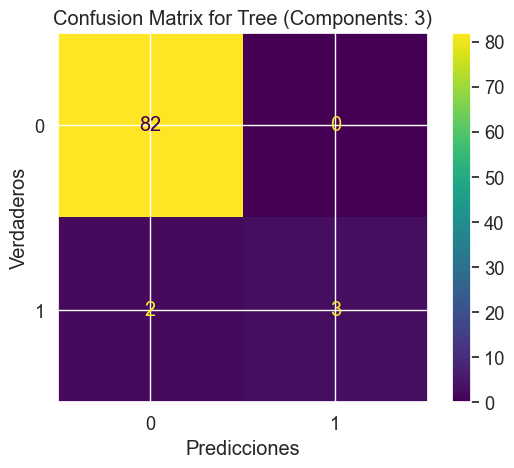

In [73]:
# Encuentra el mejor modelo y métrica en el resumen
best_model_info = df_summary[df_summary['Test_F1'] == df_summary['Test_F1'].max()].iloc[0]

# Obtener información del mejor modelo
best_components = best_model_info['Components']
best_model_name = best_model_info['Model']

# Obtener predicciones del mejor modelo
best_model_preds = results[best_components][best_model_name][1]

# Obtener matriz de confusión
conf_matrix = confusion_matrix(y_test, best_model_preds)

# Crear una visualización de la matriz de confusión
cm_display = ConfusionMatrixDisplay(conf_matrix)
cm_display.plot()
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title(f'Confusion Matrix for {best_model_name} (Components: {best_components})')
plt.show()


In [64]:
# Se presentan los mejores parámetros para cada modelo
print('PARÁMETROS DE LOS MEJORES MODELOS')
print('KNN:', knn_best_params)
print('Decision Tree:', tree_best_params)
print('SCV:', svc_best_params)

PARÁMETROS DE LOS MEJORES MODELOS
KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 5}
SCV: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


En esta perspectiva, destaca el rendimiento superior del modelo de **Árbol de Decisión** en el contexto de la reducción de dimensionalidad a 8 componentes. En este escenario específico, se observa un F1 Score de 0.77, notablemente mejor que el logrado con el enfoque inicial.

# Conclusiones

Se entrenaron tres modelos (Árbol de Decisión, K-Vecinos Cercanos y Máquina de Soporte de Vectores) utilizando dos enfoques de análisis. Por un lado, se consideraron todas las variables del conjunto de datos, y por otro, se exploraron cuatro escenarios de reducción de dimensionalidad.

En ambos enfoques, se determinó que el algoritmo más efectivo para clasificar a los pacientes, ya sea hospitalizados o no, fue el Árbol de Decisión. Sin embargo, en el primer enfoque, que empleó todas las variables del conjunto de datos, el modelo solo alcanzó un F1 Score de 0.72, lo cual se considera relativamente bajo. En contraste, con el enfoque de reducción de dimensionalidad, el modelo más destacado fue un Árbol de Decisión con una profundidad máxima de 19, utilizando el criterio Gini y con 8 componentes de reducción. En este último escenario, se logró un F1 Score de 0.77, representando un rendimiento aceptable, especialmente considerando el significativo desbalance en la clase objetivo.